# 머신 러닝 교과서 3판

# 4장 - 좋은 훈련 데이터셋 만들기 – 데이터 전처리

**아래 링크를 통해 이 노트북을 주피터 노트북 뷰어(nbviewer.jupyter.org)로 보거나 구글 코랩(colab.research.google.com)에서 실행할 수 있습니다.**

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.org/github/rickiepark/python-machine-learning-book-3rd-edition/blob/master/ch04/SequentialFeatureSelector.ipynb"><img src="https://jupyter.org/assets/share.png" width="60" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/python-machine-learning-book-3rd-edition/blob/master/ch04/SequentialFeatureSelector.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

## 4.5.4 순차 특성 선택 알고리즘

4.5절에서 사용하는 데이터셋을 로드합니다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/'
                      'ml/machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y,
                     test_size=0.3,
                     random_state=0,
                     stratify=y)

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

`SequentialFeatureSelector`를 임포트하고 최근접 이웃 분류기 객체를 준비합니다.

In [4]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

사용할 모델 객체를 첫 번째 매개변수로 전달합니다. 선택할 특성의 개수는 `n_features_to_select`에서 지정합니다. 기본값은 입력 특성의 절반입니다. 0~1 사이 실수를 지정하면 선택할 특성의 비율로 인식합니다.

`direction` 매개변수로 특성 선택 방향(전진 또는 후진)을 선택합니다. 기본값은 전진을 의미하는 `'forward'`이고 후진을 선택하려면 `'backward'`로 지정합니다.

이 클래스는 특성을 선택하기 위해 교차 검증을 사용합니다. `cv` 매개변수에서 교차 검증 횟수를 지정할 수 있습니다. 기본값은 5입니다. 회귀 모델일 경우 `KFold`, 분류 모델일 경우 `StratifiedKFold`를 사용하여 폴드를 나눕니다.

이 클래스는 하나의 특성을 선택할 때마다 현재 남은 특성 개수(m)에 대해 교차 검증을 수행하므로 `m * cv`개의 모델을 만듭니다. 이렇게 단계마다 많은 모델을 만들기 때문에 일반적으로 `RFE`나 `SelectFromModel`보다 느립니다. `n_jobs` 매개변수를 1 이상으로 지정하여 여러 코어를 사용하는 것이 좋습니다.

In [5]:
scores = []
for n_features in range(1, 13):
    sfs = SequentialFeatureSelector(knn, n_features_to_select=n_features, n_jobs=-1)
    sfs.fit(X_train_std, y_train)
    f_mask = sfs.support_
    knn.fit(X_train_std[:, f_mask], y_train)
    scores.append(knn.score(X_train_std[:, f_mask], y_train))

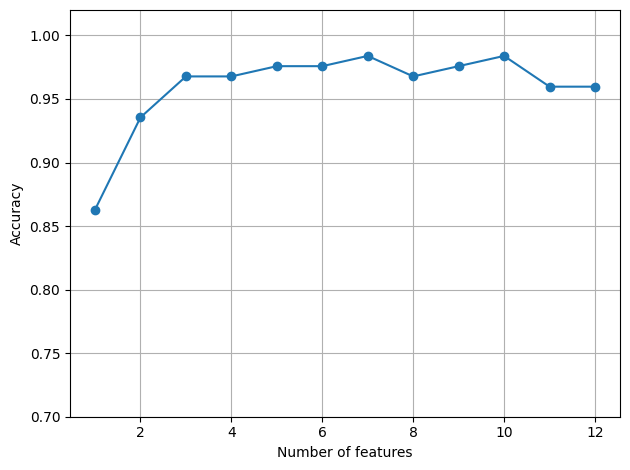

In [6]:
plt.plot(range(1, 13), scores, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('images/04_sfs.png', dpi=300)
plt.show()

In [7]:
sfs = SequentialFeatureSelector(knn, n_features_to_select=7, n_jobs=-1)
sfs.fit(X_train_std, y_train)

SequentialFeatureSelector(estimator=KNeighborsClassifier(),
                          n_features_to_select=7, n_jobs=-1)

In [8]:
print(sfs.n_features_to_select_)
f_mask = sfs.support_
df_wine.columns[1:][f_mask]

7


Index(['Alcohol', 'Ash', 'Magnesium', 'Flavanoids', 'Color intensity', 'Hue',
       'Proline'],
      dtype='object')

In [9]:
knn.fit(X_train_std[:, f_mask], y_train)
print('훈련 정확도:', knn.score(X_train_std[:, f_mask], y_train))
print('테스트 정확도:', knn.score(X_test_std[:, f_mask], y_test))

훈련 정확도: 0.9838709677419355
테스트 정확도: 0.9814814814814815
